In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn



In [2]:

LENGTH = 1.
TOTAL_TIME = 0.5


def initial_condition(x) -> torch.Tensor:
    res = torch.sin( 2*np.pi * x).reshape(-1, 1) * 0.5
    return res


In [32]:
class PINN_df(nn.Module):
    """Simple neural network accepting two features as input and returning a single output
    
    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):

        super().__init__()

        self.layer_in = nn.Linear(2, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 3)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x, t):
        x_stack = torch.cat([x, t], dim=1)        
        out = self.act(self.layer_in(x_stack))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)

def df(nn_approximator: PINN_df, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn_approximator(x, t)


def f(nn_approximator: PINN, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn_approximator(x, t)


# def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor:
#     """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
#     df_value = output
#     for _ in range(order):
#         df_value = torch.autograd.grad(
#             df_value,
#             input,
#             grad_outputs=torch.ones_like(input),
#             create_graph=True,
#             retain_graph=True,
#         )[0]

#     return df_value


# def dfdt(nn_approximator: PINN, x: torch.Tensor, t: torch.Tensor, order: int = 1):
#     """Derivative with respect to the time variable of arbitrary order"""
#     f_value = f(nn_approximator, x, t)
#     return df(f_value, t, order=order)


# def dfdx(nn_approximator: PINN, x: torch.Tensor, t: torch.Tensor, order: int = 1):
#     """Derivative with respect to the spatial variable of arbitrary order"""
#     f_value = f(nn_approximator, x, t)
#     return df(f_value, x, order=order)

In [37]:
def compute_loss(
    nn_approximator: PINN_df, x: torch.Tensor = None, t: torch.Tensor = None
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """

    # PDE residual
    print(df(nn_approximator, x, t), df(nn_approximator, x, t).shape)
    return 
    interior_loss = dfdt(nn_approximator, x, t, order=1) + f(nn_approximator, x, t) * dfdx(nn_approximator, x, t, order=1)

    # regularization term
    interior_loss_regularization = torch.clone(interior_loss)
    interior_loss_regularization = torch.autograd.grad(
        interior_loss_regularization.mean(), nn_approximator.parameters(), create_graph=True, retain_graph=True
    )[0].flatten()
    interior_loss_regularization = torch.max(interior_loss_regularization)

    # periodic boundary conditions at the domain extrema
    t_raw = torch.unique(t).reshape(-1, 1).detach().numpy()
    t_raw = torch.Tensor(t_raw)
    t_raw.requires_grad = True
    
    boundary_xi = torch.ones_like(t_raw, requires_grad=True) * x[0]
    boundary_loss_xi = f(nn_approximator, boundary_xi, t_raw)
    
    boundary_xf = torch.ones_like(t_raw, requires_grad=True) * x[-1]
    boundary_loss_xf = f(nn_approximator, boundary_xf, t_raw)
    
    # initial condition loss
    x_raw = torch.unique(x).reshape(-1, 1).detach().numpy()
    x_raw = torch.Tensor(x_raw)
    x_raw.requires_grad = True

    f_initial = initial_condition(x_raw)    
    t_initial = torch.zeros_like(x_raw)
    initial_loss_f = f(nn_approximator, x_raw, t_initial) - f_initial 
    
    # obtain the final MSE loss by averaging each loss term and summing them up
    final_loss = \
        interior_loss.pow(2).mean() + \
        initial_loss_f.pow(2).mean() + \
        boundary_loss_xf.pow(2).mean() + boundary_loss_xi.pow(2).mean() #+ \
        # interior_loss_regularization.pow(2).mean()
    
    return final_loss


def train_model(
    nn_approximator: PINN_df,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> PINN_df:

    optimizer = torch.optim.Adam(nn_approximator.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn_approximator)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch == 1: break
            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

        except KeyboardInterrupt:
            break

    return nn_approximator


def check_gradient(nn_approximator: PINN, x: torch.Tensor, t: torch.Tensor) -> bool:

    eps = 1e-4
    
    dfdx_fd = (f(nn_approximator, x + eps, t) - f(nn_approximator, x - eps, t)) / (2 * eps)
    dfdx_autodiff = dfdx(nn_approximator, x, t, order=1)
    is_matching_x = torch.allclose(dfdx_fd.T, dfdx_autodiff.T, atol=1e-2, rtol=1e-2)

    dfdt_fd = (f(nn_approximator, x, t + eps) - f(nn_approximator, x, t - eps)) / (2 * eps)
    dfdt_autodiff = dfdt(nn_approximator, x, t, order=1)
    is_matching_t = torch.allclose(dfdt_fd.T, dfdt_autodiff.T, atol=1e-2, rtol=1e-2)
    
    eps = 1e-2

    d2fdx2_fd = (f(nn_approximator, x + eps, t) - 2 * f(nn_approximator, x, t) + f(nn_approximator, x - eps, t)) / (eps ** 2)
    d2fdx2_autodiff = dfdx(nn_approximator, x, t, order=2)
    is_matching_x2 = torch.allclose(d2fdx2_fd.T, d2fdx2_autodiff.T, atol=1e-2, rtol=1e-2)

    d2fdt2_fd = (f(nn_approximator, x, t + eps) - 2 * f(nn_approximator, x, t) + f(nn_approximator, x, t - eps)) / (eps ** 2)
    d2fdt2_autodiff = dfdt(nn_approximator, x, t, order=2)
    is_matching_t2 = torch.allclose(d2fdt2_fd.T, d2fdt2_autodiff.T, atol=1e-2, rtol=1e-2)
    
    return is_matching_x and is_matching_t and is_matching_x2 and is_matching_t2


def plot_solution(nn_trained: PINN, x: torch.Tensor, t: torch.Tensor):

    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation

    
    x_raw = torch.unique(x).reshape(-1, 1)
    t_raw = torch.unique(t)
    print(t_raw.shape)
    for i in range(0, t_raw.shape[0], 20):
        fig, ax = plt.subplots()
        t_partial = torch.ones_like(x_raw) * t_raw[i]
        f_final = f(nn_trained, x_raw, t_partial)
        ax.plot(
            x_raw.detach().numpy(), f_final.detach().numpy(), label=f"Time {float(t[i])}"
        )
        ax.legend()
        plt.show()

In [38]:
if __name__ == "__main__":
    from functools import partial

    x_domain = [0.0, LENGTH]; n_points_x = 100
    t_domain = [0.0, TOTAL_TIME]; n_points_t = 100
    
    x_raw = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
    grids = torch.meshgrid(x_raw, t_raw, indexing="ij")
    
    x = grids[0].flatten().reshape(-1, 1)
    t = grids[1].flatten().reshape(-1, 1)

    nn_approximator = PINN_df(2, 15)
    # assert check_gradient(nn_approximator, x, t)
    
    compute_loss(nn_approximator, x=x, t=t)
    
    # train the PINN
    loss_fn = partial(compute_loss, x=x, t=t)
    nn_approximator_trained = train_model(
        nn_approximator, loss_fn=loss_fn, learning_rate=0.025, max_epochs=10_000
    )

    input("Plot")

    plt.figure(1)
    plt.plot(x_raw.detach().numpy(), initial_condition(x_raw).detach().numpy())
    plt.title("Initial condition")
    plt.show()

    plot_solution(nn_approximator_trained, x, t)

tensor([[-0.4013, -0.2812, -0.0053],
        [-0.4019, -0.2814, -0.0058],
        [-0.4025, -0.2817, -0.0063],
        ...,
        [-0.4877, -0.2326, -0.2528],
        [-0.4882, -0.2330, -0.2531],
        [-0.4888, -0.2335, -0.2534]], grad_fn=<AddmmBackward0>) torch.Size([10000, 3])
tensor([[-0.4013, -0.2812, -0.0053],
        [-0.4019, -0.2814, -0.0058],
        [-0.4025, -0.2817, -0.0063],
        ...,
        [-0.4877, -0.2326, -0.2528],
        [-0.4882, -0.2330, -0.2531],
        [-0.4888, -0.2335, -0.2534]], grad_fn=<AddmmBackward0>) torch.Size([10000, 3])


AttributeError: ignored

Epoch: 0 - Loss: 0.171588
Epoch: 1000 - Loss: 0.014053
Epoch: 2000 - Loss: 0.016060
Epoch: 3000 - Loss: 0.007356
Epoch: 4000 - Loss: 0.011579
Epoch: 5000 - Loss: 0.008036
Epoch: 6000 - Loss: 0.006109
Epoch: 7000 - Loss: 0.006656
Epoch: 8000 - Loss: 0.006242
Epoch: 9000 - Loss: 0.006038
Plot


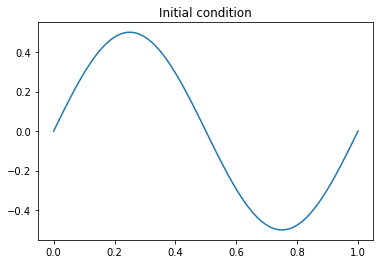

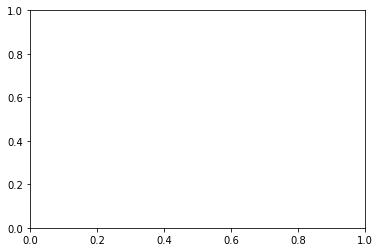

In [6]:
if __name__ == "__main__":
    from functools import partial

    x_domain = [0.0, LENGTH]; n_points_x = 100
    t_domain = [0.0, TOTAL_TIME]; n_points_t = 100
    
    x_raw = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
    grids = torch.meshgrid(x_raw, t_raw, indexing="ij")
    
    x = grids[0].flatten().reshape(-1, 1)
    t = grids[1].flatten().reshape(-1, 1)

    nn_approximator = PINN_df(2, 15)
    assert check_gradient(nn_approximator, x, t)
    
    compute_loss(nn_approximator, x=x, t=t)
    
    # train the PINN
    loss_fn = partial(compute_loss, x=x, t=t)
    nn_approximator_trained = train_model(
        nn_approximator, loss_fn=loss_fn, learning_rate=0.025, max_epochs=10_000
    )

    input("Plot")

    plt.figure(1)
    plt.plot(x_raw.detach().numpy(), initial_condition(x_raw).detach().numpy())
    plt.title("Initial condition")
    plt.show()

    plot_solution(nn_approximator_trained, x, t)

torch.Size([100])


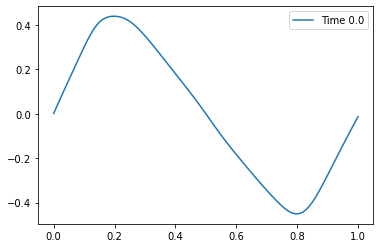

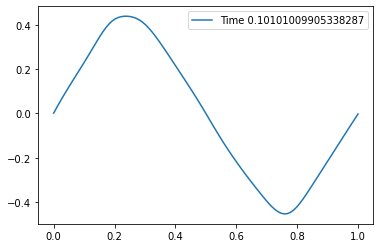

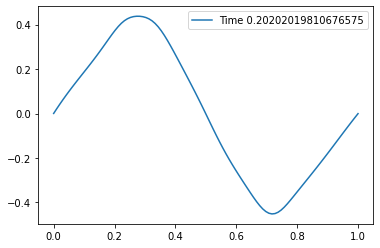

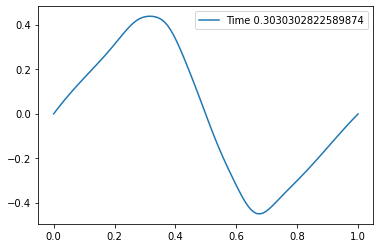

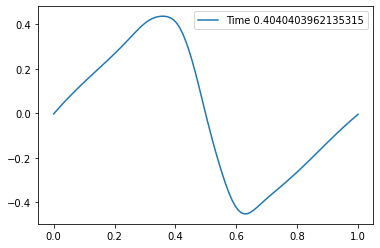

In [30]:
plot_solution(nn_approximator_trained, x, t)

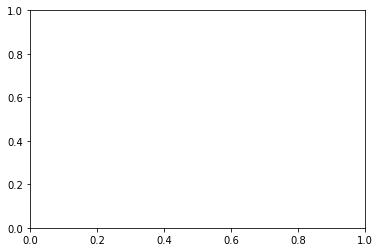

In [8]:
plot_solution(nn_approximator_trained, x, t)